In [1]:
import os
import zipfile
import numpy as np
from PIL import Image
import cv2  # OpenCV for image processing
from tqdm import tqdm  # For a nice progress bar
import matplotlib.pyplot as plt

# --- 1. Unzip the Dataset ---

# Set the name of the zip file you uploaded to Colab
zip_file_name = '2018 Data Science Bowl dataset.zip'
# Directory where we'll extract the data
data_dir = '/content/data/'

print(f"Starting to unzip {zip_file_name}...")

# Create the directory if it doesn't exist
os.makedirs(data_dir, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(data_dir)

print(f"Successfully unzipped to {data_dir}")

Starting to unzip 2018 Data Science Bowl dataset.zip...
Successfully unzipped to /content/data/


In [2]:
# If the code fails here, we just need to adjust this one line.
# Define the path to the unzipped training data
train_path = os.path.join(data_dir, 'data science bowl 2018', 'stage1_train 2')
image_ids = os.listdir(train_path)

# --- 2. Load and Preprocess the Data ---

# Define the image size you want to use.
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3 # We'll use RGB

# Create lists to hold our processed data
X_train = [] # Will hold images
Y_train_interiors = [] # Will hold the interior masks
Y_train_borders = []   # Will hold the border masks

print(f"\nProcessing {len(image_ids)} images...")

# Define a kernel for erosion (to find interiors)
erosion_kernel = np.ones((3, 3), np.uint8)

for image_id in tqdm(image_ids):  # tqdm gives us a progress bar
    image_folder = os.path.join(train_path, image_id)

    # Check if it's actually a directory (skips files like .DS_Store)
    if not os.path.isdir(image_folder):
        continue

    image_path = os.path.join(image_folder, 'images', image_id + '.png')
    mask_dir = os.path.join(image_folder, 'masks')

    # --- Load and resize the main image ---
    img = Image.open(image_path).convert('RGB') # Ensure 3 channels
    img = img.resize((IMG_WIDTH, IMG_HEIGHT))
    X_train.append(np.array(img))

    # --- Create the target masks ---
    mask_interior = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.bool_)
    mask_combined = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.bool_)

    # Loop over all the individual mask files for this image
    for mask_file in os.listdir(mask_dir):
        mask_path = os.path.join(mask_dir, mask_file)

        # Load the individual mask
        mask = Image.open(mask_path)
        mask = mask.resize((IMG_WIDTH, IMG_HEIGHT))
        mask = np.array(mask) > 0 # Convert to boolean (True/False)

        # 1. Add to the combined mask
        mask_combined = np.maximum(mask_combined, mask)

        # 2. Find the interior by "eroding" the mask
        interior = cv2.erode(mask.astype(np.uint8), erosion_kernel, iterations=1)
        mask_interior = np.maximum(mask_interior, interior > 0)

    # The border is the combined mask MINUS the interiors
    mask_border = mask_combined & ~mask_interior

    Y_train_interiors.append(mask_interior)
    Y_train_borders.append(mask_border)


Processing 670 images...


100%|██████████| 670/670 [01:09<00:00,  9.66it/s]


In [3]:
# --- 3. Convert Lists to NumPy Arrays ---

X_train = np.array(X_train)
# We add a new dimension (1) at the end for the "channel"
Y_train_interiors = np.expand_dims(np.array(Y_train_interiors), axis=-1)
Y_train_borders = np.expand_dims(np.array(Y_train_borders), axis=-1)

print("\n--- Processing Complete ---")
print(f"X_train (images) shape: {X_train.shape}")
print(f"Y_train_interiors shape:  {Y_train_interiors.shape}")
print(f"Y_train_borders shape:    {Y_train_borders.shape}")


--- Processing Complete ---
X_train (images) shape: (670, 128, 128, 3)
Y_train_interiors shape:  (670, 128, 128, 1)
Y_train_borders shape:    (670, 128, 128, 1)


--- Starting EDA ---
Generating Plot 1: Sample Image + Mask Overlay...


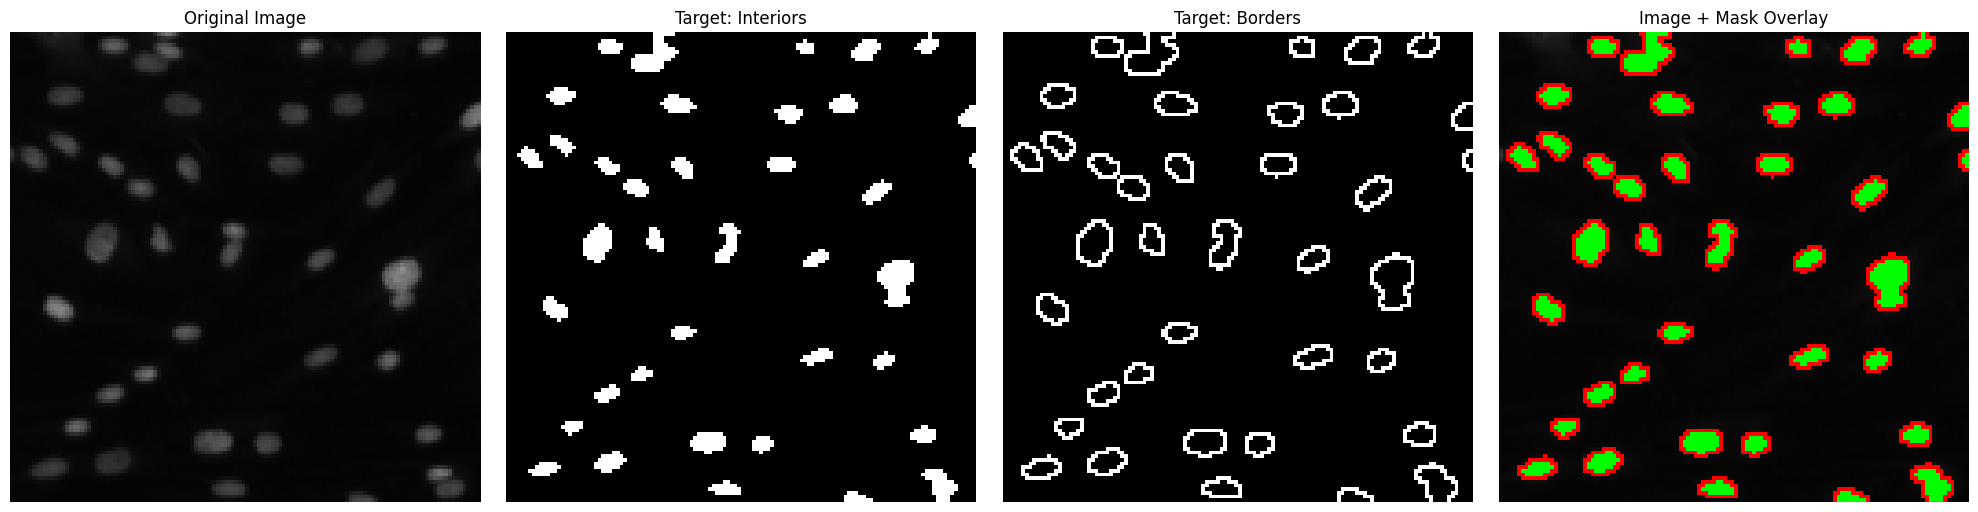

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns # For nicer plots

# --- 0. EDA Assumptions ---
# This script assumes the following variables exist in memory
# from the previous data loading script:
#
# - X_train (shape: (670, 128, 128, 3))
# - Y_train_interiors (shape: (670, 128, 128, 1))
# - Y_train_borders (shape: (670, 128, 128, 1))
# - train_path (e.g., '/content/data/stage1_train')

print("--- Starting EDA ---")

# --- 1. Plot: Sample Image + Mask Overlay ---
# Why: To visually verify our preprocessing (interiors vs. borders)
# and ensure our data is correct.

print("Generating Plot 1: Sample Image + Mask Overlay...")

# Pick a random image to display
ix = np.random.randint(0, len(X_train))
img = X_train[ix]
interior = Y_train_interiors[ix].squeeze() # Remove the last dimension
border = Y_train_borders[ix].squeeze()

# Create an overlay image
# 1. Start with the original image
overlay = img.copy()

# 2. Find pixels for interior (green) and border (red)
# We use .squeeze() to make the masks 2D (128, 128)
interior_pixels = (Y_train_interiors[ix].squeeze() > 0)
border_pixels = (Y_train_borders[ix].squeeze() > 0)

# 3. Color the pixels
# Set interior to green [0, 255, 0]
overlay[interior_pixels] = [0, 255, 0]
# Set border to red [255, 0, 0]
overlay[border_pixels] = [255, 0, 0]

# 4. Create the plot
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

axes[0].imshow(img)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(interior, cmap='gray')
axes[1].set_title('Target: Interiors')
axes[1].axis('off')

axes[2].imshow(border, cmap='gray')
axes[2].set_title('Target: Borders')
axes[2].axis('off')

axes[3].imshow(overlay)
axes[3].set_title('Image + Mask Overlay')
axes[3].axis('off')

plt.tight_layout()
plt.savefig('eda_plot_1_overlay.png')
plt.show()

Generating Plot 2: Class Distribution...
  Background: 8962535 pixels (81.65%)
  Interior:   1247880 pixels (11.37%)
  Border:     766865 pixels (6.99%)


/tmp/ipython-input-1854324603.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Class', y='Pixel Count', data=class_data, palette='deep')


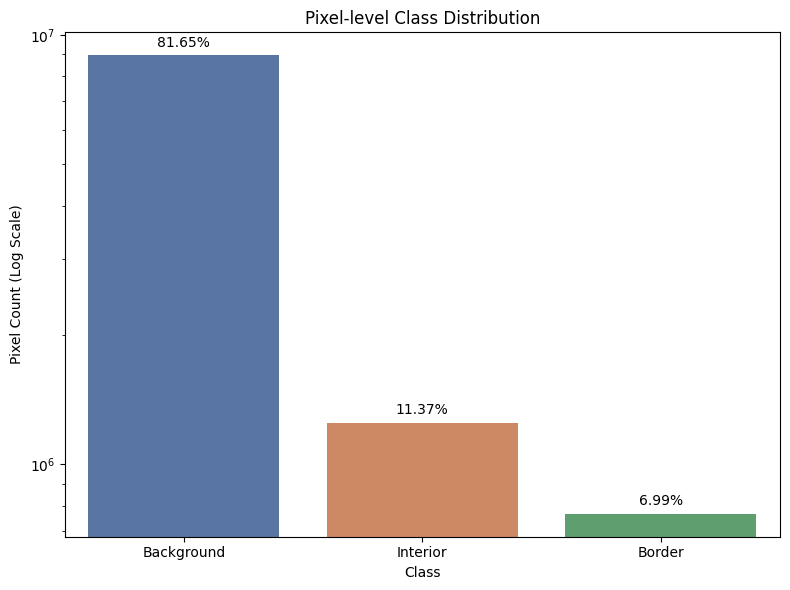

In [5]:
# --- 2. Plot: Class Distribution (Pixel-level) ---
# Why: To check for class imbalance at the pixel level.
# This will inform our choice of loss function.

print("Generating Plot 2: Class Distribution...")

# Calculate pixel counts
total_pixels = Y_train_interiors.size
interior_pixels = np.sum(Y_train_interiors)
border_pixels = np.sum(Y_train_borders)
background_pixels = total_pixels - interior_pixels - border_pixels

# Create a DataFrame for Seaborn
class_data = {
    'Class': ['Background', 'Interior', 'Border'],
    'Pixel Count': [background_pixels, interior_pixels, border_pixels]
}
class_percents = (np.array([background_pixels, interior_pixels, border_pixels]) / total_pixels) * 100

print(f"  Background: {background_pixels} pixels ({class_percents[0]:.2f}%)")
print(f"  Interior:   {interior_pixels} pixels ({class_percents[1]:.2f}%)")
print(f"  Border:     {border_pixels} pixels ({class_percents[2]:.2f}%)")

plt.figure(figsize=(8, 6))
ax = sns.barplot(x='Class', y='Pixel Count', data=class_data, palette='deep')
ax.set_title('Pixel-level Class Distribution')
ax.set_yscale('log') # Use a log scale, otherwise Background will make others invisible
ax.set_ylabel('Pixel Count (Log Scale)')

# Add percentage labels
labels = [f'{p:.2f}%' for p in class_percents]
for i, p in enumerate(ax.patches):
    ax.annotate(labels[i],
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points')

plt.tight_layout()
plt.savefig('eda_plot_2_class_distribution.png')
plt.show()

In [6]:
# --- 3. Analysis: Image Size & Aspect Ratio ---
# Why: To check for consistency.
# In our case, we ALREADY pre-processed the images to be uniform.

print("\nAnalyzing Plot 3: Image Size & Aspect Ratio...")
print(f"  All images have been resized to a uniform size: {X_train.shape[1:]}")
print("  As a result, a histogram is not necessary. This uniformity is good for our model.")


Analyzing Plot 3: Image Size & Aspect Ratio...
  All images have been resized to a uniform size: (128, 128, 3)
  As a result, a histogram is not necessary. This uniformity is good for our model.


Generating Plot 4: Pixel Intensity Histogram...


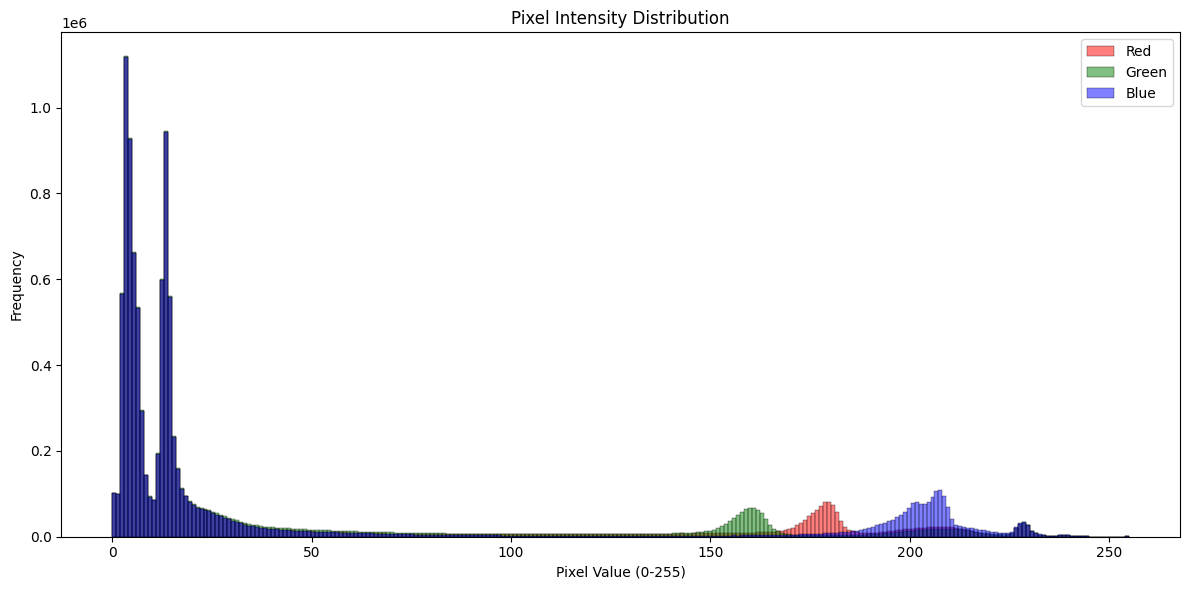

In [7]:
# --- 4. Plot: Pixel Intensity Histogram ---
# Why: To check the distribution of pixel values (0-255).
# This confirms if we need normalization.

print("Generating Plot 4: Pixel Intensity Histogram...")

plt.figure(figsize=(12, 6))

# Flatten the pixel values for each channel
# X_train is (670, 128, 128, 3)
red_channel = X_train[:, :, :, 0].ravel()
green_channel = X_train[:, :, :, 1].ravel()
blue_channel = X_train[:, :, :, 2].ravel()

# Plot histograms with transparency
sns.histplot(red_channel, color='red', label='Red', kde=False, alpha=0.5, bins=256)
sns.histplot(green_channel, color='green', label='Green', kde=False, alpha=0.5, bins=256)
sns.histplot(blue_channel, color='blue', label='Blue', kde=False, alpha=0.5, bins=256)

plt.title('Pixel Intensity Distribution')
plt.xlabel('Pixel Value (0-255)')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.savefig('eda_plot_4_intensity.png')
plt.show()

Generating Plot 5 (Alternative): Nuclei Count Histogram...


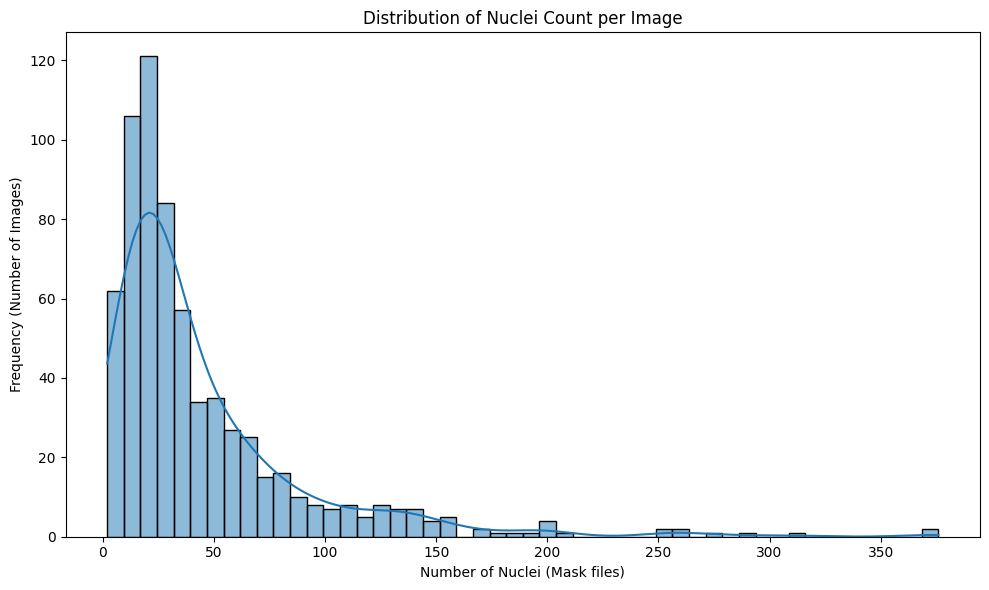

In [8]:
# --- 5. ALTERNATIVE Plot: Nuclei Count Per Image ---
# Why: This is more useful than image size. It shows the
# distribution of the *number of objects* we need to find.

print("Generating Plot 5 (Alternative): Nuclei Count Histogram...")

nuclei_counts = []
image_ids = os.listdir(train_path)

for image_id in image_ids:
    image_folder = os.path.join(train_path, image_id)
    if not os.path.isdir(image_folder):
        continue
    mask_dir = os.path.join(image_folder, 'masks')
    nuclei_counts.append(len(os.listdir(mask_dir)))

plt.figure(figsize=(10, 6))
sns.histplot(nuclei_counts, bins=50, kde=True)
plt.title('Distribution of Nuclei Count per Image')
plt.xlabel('Number of Nuclei (Mask files)')
plt.ylabel('Frequency (Number of Images)')
plt.tight_layout()
plt.savefig('eda_plot_5_nuclei_count.png')
plt.show()

Generating Plot 6 (Alternative): Mask Area Histogram...


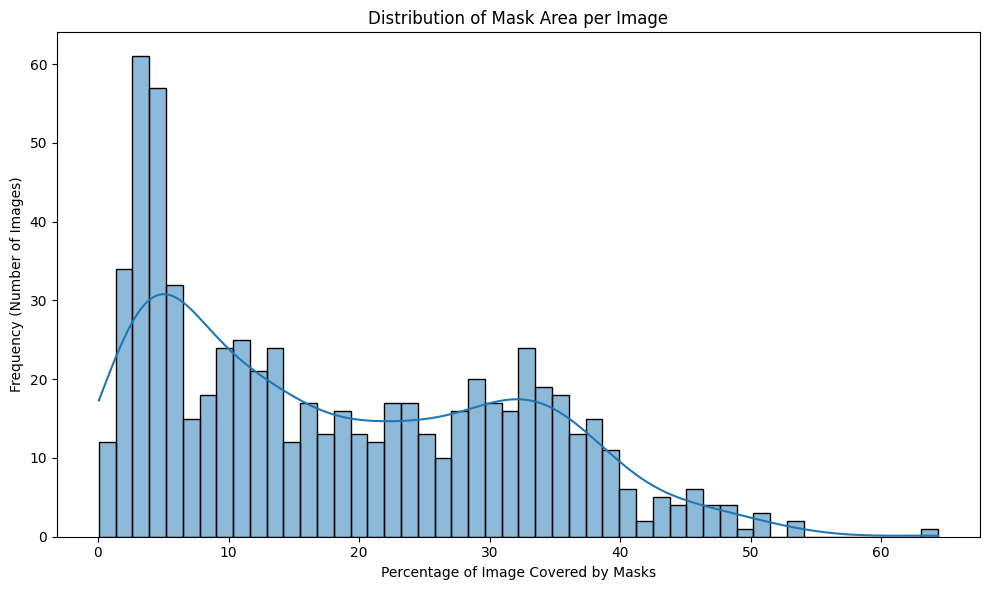


--- EDA Complete ---


In [9]:
# --- 6. ALTERNATIVE Plot: Mask Area Per Image ---
# Why: Shows the distribution of the total *percentage* of
# an image that is covered by nuclei.

print("Generating Plot 6 (Alternative): Mask Area Histogram...")

# Combine interiors and borders
Y_train_combined = (Y_train_interiors + Y_train_borders) > 0

# Calculate sum of 'True' pixels for each image
# axis=(1, 2, 3) means sum across height, width, and channel dims
mask_areas = np.sum(Y_train_combined, axis=(1, 2, 3))

# Calculate as a percentage of total image area
image_area = IMG_HEIGHT * IMG_WIDTH
mask_area_percent = (mask_areas / image_area) * 100

plt.figure(figsize=(10, 6))
sns.histplot(mask_area_percent, bins=50, kde=True)
plt.title('Distribution of Mask Area per Image')
plt.xlabel('Percentage of Image Covered by Masks')
plt.ylabel('Frequency (Number of Images)')
plt.tight_layout()
plt.savefig('eda_plot_6_mask_area.png')
plt.show()

print("\n--- EDA Complete ---")

In [10]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

print("--- Starting Final Preprocessing ---")

# --- 1. Normalize X_train ---
# Scale images from [0, 255] to [0.0, 1.0]
X_train_normalized = X_train.astype('float32') / 255.0

print(f"X_train normalized. Min: {X_train_normalized.min()}, Max: {X_train_normalized.max()}")

--- Starting Final Preprocessing ---
X_train normalized. Min: 0.0, Max: 1.0


In [11]:
# --- 2. Create 3-Class Target Mask ---
# We will create a single integer mask Y_train_final
# Shape will be (670, 128, 128, 1)
# Class 0: Background (default)
# Class 1: Interior
# Class 2: Border

# Start with a mask of all zeros (Background)
Y_train_final = np.zeros(Y_train_interiors.shape, dtype='int32')

# Squeeze masks to make indexing easier (removes the last dimension)
interiors_squeezed = Y_train_interiors.squeeze()
borders_squeezed = Y_train_borders.squeeze()

# Add the 'Interior' pixels (Class 1)
Y_train_final[interiors_squeezed] = 1

# Add the 'Border' pixels (Class 2)
# This will overwrite any 'Interior' pixels that were also
# on the border, which is the correct priority.
Y_train_final[borders_squeezed] = 2

# Check our new class distribution
print("\nNew Target Mask (Y_train_final) created with classes:")
print(f"  Class 0 (Background) pixels: {np.sum(Y_train_final == 0)}")
print(f"  Class 1 (Interior) pixels:   {np.sum(Y_train_final == 1)}")
print(f"  Class 2 (Border) pixels:     {np.sum(Y_train_final == 2)}")


New Target Mask (Y_train_final) created with classes:
  Class 0 (Background) pixels: 8962535
  Class 1 (Interior) pixels:   1247880
  Class 2 (Border) pixels:     766865


In [12]:
# --- 3. Create Training and Validation Split ---
# This is crucial for training a robust model.
VAL_SPLIT = 0.1
RANDOM_SEED = 42

X_train_processed, X_val, Y_train_processed, Y_val = train_test_split(
    X_train_normalized,
    Y_train_final,
    test_size=VAL_SPLIT,
    random_state=RANDOM_SEED
)

print("\n--- Preprocessing Complete ---")
print(f"Total samples:   {len(X_train_normalized)}")
print(f"Training images: {len(X_train_processed)} (Shape: {X_train_processed.shape})")
print(f"Training masks:  {len(Y_train_processed)} (Shape: {Y_train_processed.shape})")
print(f"Validation images: {len(X_val)} (Shape: {X_val.shape})")
print(f"Validation masks:  {len(Y_val)} (Shape: {Y_val.shape})")

# The data is now ready for the model.
# The variables you will use for training are:
# - X_train_processed
# - Y_train_processed
# - X_val
# - Y_val


--- Preprocessing Complete ---
Total samples:   670
Training images: 603 (Shape: (603, 128, 128, 3))
Training masks:  603 (Shape: (603, 128, 128, 1))
Validation images: 67 (Shape: (67, 128, 128, 3))
Validation masks:  67 (Shape: (67, 128, 128, 1))


In [13]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Build the U-Net Model ---

# We'll build a standard U-Net architecture.
# We'll use the Keras Functional API.

IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3
NUM_CLASSES = 3  # Background, Interior, Border

# --- Encoder (Contracting Path) ---

inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = inputs # s is the "current" state of the network

# Convert images to float32 (if not already)
s = tf.keras.layers.Lambda(lambda x: tf.cast(x, 'float32'))(s)

# Block 1
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = Dropout(0.1)(c1)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = MaxPooling2D((2, 2))(c1)

# Block 2
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = Dropout(0.1)(c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = MaxPooling2D((2, 2))(c2)

# Block 3
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = MaxPooling2D((2, 2))(c3)

# Block 4
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = MaxPooling2D((2, 2))(c4)

# Bottleneck
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = Dropout(0.3)(c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

# --- Decoder (Expanding Path) ---

# Block 6 (Up-conv + skip)
u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = concatenate([u6, c4]) # Skip connection
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

# Block 7
u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = Dropout(0.2)(c7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

# Block 8
u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = Dropout(0.1)(c8)
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

# Block 9
u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = concatenate([u9, c1])
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = Dropout(0.1)(c9)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

# --- Output Layer ---
# This layer MUST match our data:
# - Filters = 3 (for our 3 classes: 0, 1, 2)
# - Activation = 'softmax' (to get a probability for each class)
outputs = Conv2D(NUM_CLASSES, (1, 1), activation='softmax')(c9)

# Create the model
model = Model(inputs=[inputs], outputs=[outputs])

print("--- Model Built Successfully ---")
model.summary()

--- Model Built Successfully ---


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        448 │ lambda[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    147,584 │ dropout_3[0][0] 

 Total params: 1,941,139 (7.40 MB)

 Trainable params: 1,941,139 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# --- 2. Compile the Model ---
# This is a critical step.
# Optimizer: 'adam' is a great default.
# Loss: 'sparse_categorical_crossentropy' is REQUIRED because our
#       Y_train_processed is (128, 128, 1) with integer classes (0, 1, 2).
# Metrics: 'sparse_categorical_accuracy' is the correct accuracy for this loss.

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

print("--- Model Compiled Successfully ---")

--- Model Compiled Successfully ---


In [15]:
# --- 3. Train the Model ---
# We use the variables from our preprocessing script:
# - X_train_processed, Y_train_processed
# - X_val, Y_val

EPOCHS = 25
BATCH_SIZE = 32

# This assumes your preprocessed variables are in memory:
# X_train_processed, Y_train_processed, X_val, Y_val

print("--- Starting Model Training ---")
history = model.fit(
    X_train_processed,
    Y_train_processed,
    validation_data=(X_val, Y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

print("--- Model Training Complete ---")

--- Starting Model Training ---
Epoch 1/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - loss: 1.0305 - sparse_categorical_accuracy: 0.5640 - val_loss: 0.7854 - val_sparse_categorical_accuracy: 0.8205
Epoch 2/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.6832 - sparse_categorical_accuracy: 0.8088 - val_loss: 0.5161 - val_sparse_categorical_accuracy: 0.8205
Epoch 3/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.5210 - sparse_categorical_accuracy: 0.8177 - val_loss: 0.4534 - val_sparse_categorical_accuracy: 0.8205
Epoch 4/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.4253 - sparse_categorical_accuracy: 0.8195 - val_loss: 0.3435 - val_sparse_categorical_accuracy: 0.8210
Epoch 5/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.3467 - sparse_categorical_accuracy: 0.8245 - val_loss: 0.2984 - val_sparse_categorical_accuracy: 0.8766
Epoch 6/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.3070 - sparse_categorical_accuracy: 0.8799 - val_loss: 0.2311 - val_sparse_categori

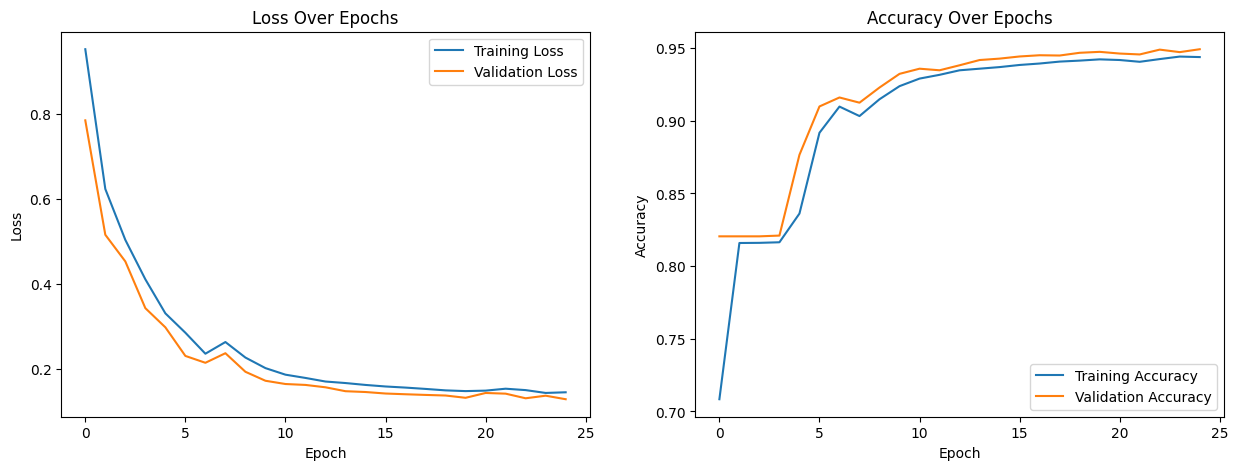

In [16]:
# --- 4. Evaluate and Visualize Results ---

# --- Plot Training History ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot Loss
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss Over Epochs')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot Accuracy
ax2.plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
ax2.set_title('Accuracy Over Epochs')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()


--- Visualizing Predictions ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


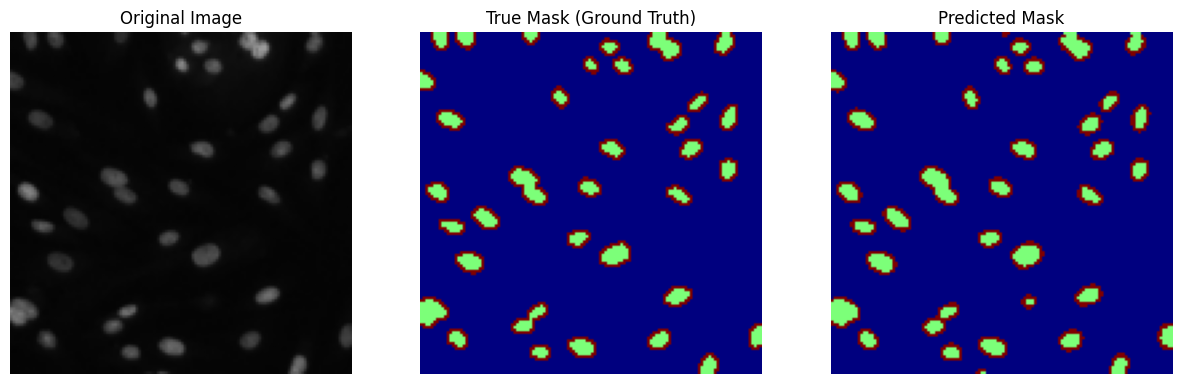

In [17]:
# --- Plot Predictions ---
# We will pick a random image from the validation set
# and show the original, the true mask, and the predicted mask.

print("\n--- Visualizing Predictions ---")

# Pick a random index from the validation set
ix = np.random.randint(0, len(X_val))

# Get the image, true mask, and prediction
img = X_val[ix]
true_mask = Y_val[ix]

# Predict: model.predict returns (1, 128, 128, 3) with probabilities
pred_mask_probs = model.predict(np.expand_dims(img, axis=0))

# Convert probabilities to class labels (0, 1, or 2) by
# finding the channel with the highest probability (np.argmax)
pred_mask = np.argmax(pred_mask_probs[0], axis=-1)

# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.imshow(img)
ax1.set_title('Original Image')
ax1.axis('off')

# .squeeze() removes the (1) channel for plotting
ax2.imshow(true_mask.squeeze(), cmap='jet', vmin=0, vmax=2)
ax2.set_title('True Mask (Ground Truth)')
ax2.axis('off')

ax3.imshow(pred_mask, cmap='jet', vmin=0, vmax=2)
ax3.set_title('Predicted Mask')
ax3.axis('off')

plt.show()

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import tensorflow as tf

print("--- 1. Evaluating Model on Validation Set ---")

# --- Summary Statistics ---

# Run model.evaluate to get the loss and accuracy on the validation set
val_loss, val_accuracy = model.evaluate(X_val, Y_val)

# Calculate the statistics you requested
total_pixels = Y_val.size
correct_pixels = int(total_pixels * val_accuracy)
incorrect_pixels = total_pixels - correct_pixels

print("\n--- Summary Statistics (on Validation Set) ---")
print(f"Total Pixels (Z):     {total_pixels}")
print(f"Correct Pixels (X):   {correct_pixels}")
print(f"Incorrect Pixels (Y): {incorrect_pixels}")
print(f"Validation Accuracy:  {val_accuracy:.4f}")
print(f"Validation Loss:      {val_loss:.4f}")

--- 1. Evaluating Model on Validation Set ---
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1320 - sparse_categorical_accuracy: 0.9485

--- Summary Statistics (on Validation Set) ---
Total Pixels (Z):     1097728
Correct Pixels (X):   1042033
Incorrect Pixels (Y): 55695
Validation Accuracy:  0.9493
Validation Loss:      0.1292



--- 4. Generating Pixel-level Confusion Matrix ---
Running predictions for entire validation set...
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 391ms/step


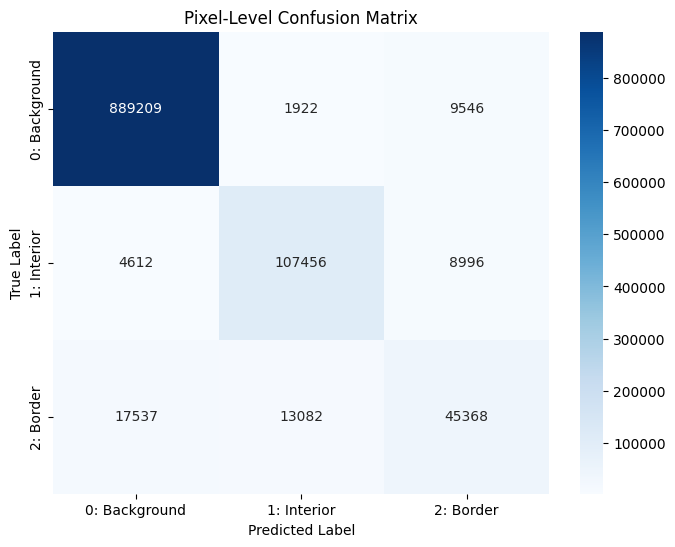


--- Evaluation Complete ---


In [20]:
# --- 4. Plot: Confusion Matrix (Pixel-level) ---
# This shows exactly which classes the model is confusing
# (e.g., is it confusing 'Border' with 'Interior'?)

print("\n--- 4. Generating Pixel-level Confusion Matrix ---")

# We need all predictions for the validation set
print("Running predictions for entire validation set...")
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=-1)

# Flatten the arrays to 1D for sklearn
y_true_flat = Y_val.ravel()
y_pred_flat = y_pred.ravel()

# Calculate the confusion matrix
cm = confusion_matrix(y_true_flat, y_pred_flat)
class_names = ['0: Background', '1: Interior', '2: Border']

# Plot as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Pixel-Level Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("\n--- Evaluation Complete ---")

In [21]:
print("\n--- 2. Converting model to .tflite format ---")

# Define the output path for the TFLite model
tflite_model_path = 'unet_nuclei_model.tflite'

# 1. Create the TFLiteConverter
# We point it to the .keras file we just saved
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# 2. (Optional but Recommended) Enable optimizations
# This applies default optimizations like weight quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# 3. Convert the model
tflite_model = converter.convert()

# 4. Save the TFLite model to a file
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"Model converted and saved successfully to: {tflite_model_path}")
print(f"File size: {os.path.getsize(tflite_model_path) / 1e6:.2f} MB")

# You can now find 'unet_nuclei_model.tflite' in your Colab file browser
# and download it.


--- 2. Converting model to .tflite format ---
Saved artifact at '/tmp/tmp05fd5m3i'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None)
Captures:
  136022660208144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136022660207760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136022660210832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136022660211600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136022660210064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136022660211216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136022660211408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136022660213328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136022660213520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136022660215248: TensorSpec